In [10]:
import numpy as np
import cv2
import imutils
from skimage.filters import threshold_local
import matplotlib.pyplot as plt

In [11]:
def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [12]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Computing the dimensions of the new image
    widthA = np.sqrt(((br[0] - bl[0])**2) + ((br[1] - bl[1])**2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

STEP 1: Edge Detection


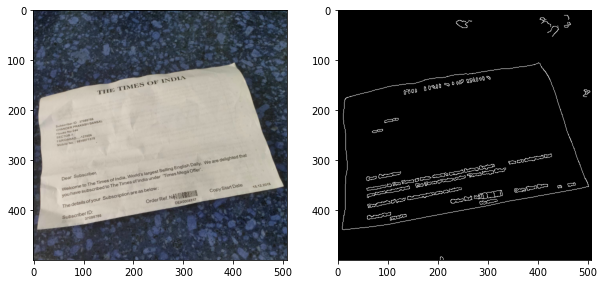

In [20]:
## Detecting Edges
image = cv2.imread(r"D:\Users\DELL\Desktop\Computer Vision\OpenCV Tutorial\Scan.jpeg")
#image = image[30:480, 30:303]
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(gray, 75, 200)

print("STEP 1: Edge Detection")
cv2.imshow("Image", image)
cv2.imshow("Edged", edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

fig = plt.figure(figsize = (10, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.imshow(edged, cmap='gray')

STEP 2: Find contours of paper


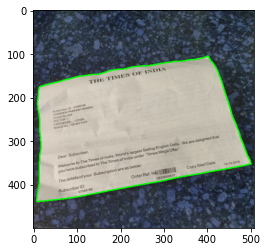

In [21]:
## Finding Contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST,
                       cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    
    if len(approx) == 4:
        screenCnt = approx
        break
        
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [cnts[0]], -1, (0, 255, 0), 2)
cv2.imshow("Outline", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(image)

STEP 3: Apply perspective transform


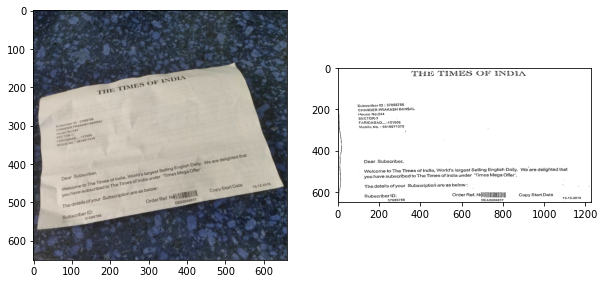

In [23]:
## Applying a Perspective Transform
warped = four_point_transform(orig, screenCnt.reshape(4, 2)*ratio)

warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset=10, method="gaussian")
warped = (warped>T).astype("uint8")*255

print("STEP 3: Apply perspective transform")
cv2.imshow("Original", imutils.resize(orig, height = 650))
cv2.imshow("Scanned", imutils.resize(warped, height = 650))
cv2.waitKey(0)

fig = plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(imutils.resize(orig, height = 650))
fig.add_subplot(1, 2, 2)
plt.imshow(imutils.resize(warped, height = 650), cmap='gray')